In [1]:
# first import all of the packages required in this entire project:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from glob import glob
import copy
import joblib
from tqdm import tqdm
tqdm.pandas()
import gc
from collections import defaultdict
import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.optim import lr_scheduler
import cv2
import matplotlib
matplotlib.style.use('ggplot')
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
Image.MAX_IMAGE_PIXELS = None
pd.set_option('display.float_format', '{:.2f}'.format)
import segmentation_models_pytorch as smp
from sklearn.preprocessing import KBinsDiscretizer

### Load train_df and calculate mean_std_dataset if not calculated:

In [2]:
train_df_src = r"\\shelter\Kyu\unstain2mask\poc\train_df.xlsx"
train_df = pd.read_excel(train_df_src)
# de-string the comp and comp_freq:
train_df["composition"] = train_df["composition"].apply(lambda x: np.fromstring(x[1:-1],dtype=np.float32, sep= ' '))
train_df["composition_freq"] = train_df["composition_freq"].apply(lambda x: np.fromstring(x[1:-1],dtype=np.float32, sep= ' '))
train_df

,Unnamed: 0,id,wsi_name,image_path,mask_path,composition,composition_freq
0,0,44930_16605xy0001,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,44930_17629xy0002,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,44930_18653xy0003,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,44930_19677xy0004,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,44930_20701xy0005,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
7195,7195,142210_89309xy7197,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7196,7196,142210_90333xy7198,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7197,7197,142210_91357xy7199,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7198,7198,142210_92381xy7200,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [3]:
find_mean_std_dataset = False# if false, already found it. Turn to true if you want to find std of mean of another dataset.

if find_mean_std_dataset:
    class Unstain2StainData(Dataset):
        def __init__(self,df,transform=None):
            self.df = df
            self.directory = df["image_path"].tolist()
            self.transform = transform

        def __len__(self):
            return int(len(self.directory))

        def __getitem__(self,idx):
            path = self.directory[idx]
            image = cv2.imread(path, cv2.COLOR_BGR2RGB)

            if self.transform is not None:
                image = self.transform(image = image)['image']
            return image

    device      = torch.device('cpu')
    num_workers = 0
    image_size  = 384
    batch_size  = 4

    augmentations = A.Compose([A.Resize(height= image_size ,width = image_size ),
                                       A.Normalize(mean=(0,0,0), std=(1,1,1)),
                                       ToTensorV2()])

    unstain2stain_dataset = Unstain2StainData(df = train_df, transform = augmentations)# data loader
    image_loader = DataLoader(unstain2stain_dataset,
                              batch_size  = batch_size,
                              shuffle     = False,
                              num_workers = num_workers,
                              pin_memory  = True)

    images = next(iter(image_loader))
    print("Images have a tensor size of {}.".
          format(images.size()))
    # placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs in tqdm(image_loader,colour='red'):
        psum    += inputs.sum(axis = [0, 2, 3]) # sum over axis 1
        psum_sq += (inputs ** 2).sum(axis = [0, 2, 3]) # sum over axis 1

    # pixel count
    count = len(train_df) * image_size * image_size

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    print('mean: ' + str(total_mean))
    print('std:  ' + str(total_std))

    #mean=[0.8989, 0.9101, 0.9236], std=[0.0377, 0.0389, 0.0389]

In [4]:
# all model configs go here so that they can be changed when we want to:
class model_config:
    seed = 42
    encoder_name = "tu-efficientnetv2_m" # from https://smp.readthedocs.io/en/latest/encoders_timm.html
    train_batch_size = 16
    valid_batch_size = 32
    epochs = 5
    learning_rate = 0.001
    scheduler = "CosineAnnealingLR"
    T_max = int(30000/train_batch_size*epochs) # for cosineannealingLR, explore different values
    weight_decay = 1e-6 # explore different weight decay (Adam optimizer)
    n_accumulate = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    iters_to_accumulate = max(1,32//train_batch_size) # for scaling accumulated gradients
    eta_min = 1e-5
    model_save_directory = os.path.join(os.getcwd(),"model") #assuming os.getcwd is the current training script directory

In [5]:
# sets the seed of the entire notebook so results are the same every time we run for reproducibility. no randomness, everything is controlled.
def set_seed(seed = 42):
    np.random.seed(seed) #numpy specific random
    random.seed(seed) # python specific random (also for albumentation augmentations)
    torch.manual_seed(seed) # torch specific random
    torch.cuda.manual_seed(seed) # cuda specific random
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # when deterministic = true, benchmark = False, otherwise might not be deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)  # set a fixed value for the hash seed, for hases like dictionary

set_seed(model_config.seed)

In [6]:
# add stratifiedkfold to df:
new_df_train = train_df.copy(deep=True)
strat_kfold = StratifiedKFold(shuffle = True, random_state = 42) #use default n_split = 5, random_state for reproducibility
composition_array = np.stack(new_df_train["composition"])  # Convert composition column to a numpy array
target_array = np.sum(composition_array, axis=1)
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')  # Adjust n_bins as needed
target_array = est.fit_transform(target_array.reshape(-1, 1)).flatten().astype(int)

#split on white and non-white and add a new column fold to it:
for each_fold, (idx1,idx2) in enumerate(strat_kfold.split(X = composition_array, y = target_array)):
    new_df_train.loc[idx2,'fold'] = int(each_fold) #create new fold column with the fold number (up to 5)

new_df_train["fold"] = new_df_train["fold"].apply(lambda x: int(x)) # somehow doesn't turn to int, so change to int, fold from 0~4

In [7]:
new_df_train

,Unnamed: 0,id,wsi_name,image_path,mask_path,composition,composition_freq,fold
0,0,44930_16605xy0001,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
1,1,44930_17629xy0002,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
2,2,44930_18653xy0003,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
3,3,44930_19677xy0004,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,4,44930_20701xy0005,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...
7195,7195,142210_89309xy7197,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
7196,7196,142210_90333xy7198,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
7197,7197,142210_91357xy7199,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
7198,7198,142210_92381xy7200,OTS_14684_3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,\\shelter\Kyu\unstain2mask\masks\OTS_14684_3\1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3


In [8]:
np.set_printoptions(suppress=True, precision=8)
fold_composition_sum = new_df_train.groupby('fold')['composition'].sum()
for fold, composition_sum in fold_composition_sum.items():
    print(f"Fold {fold}:")
    print(composition_sum)
    print()

Fold 0:
[  1.5899998   5.238       1.324       2.36        1.8030001   3.1499999
   2.331       3.2239997   2.3339996 327.50507   271.42706   817.7072   ]

Fold 1:
[  1.0839999    6.839999     0.67499995   2.2100005    2.14
   6.6909995    2.472        3.0980005    3.2470005  314.01602
 283.8301     813.69354   ]

Fold 2:
[  1.1129999    8.576        0.69799995   1.78         1.7740002
   4.311        1.555        2.0419998    3.1969998  309.63898
 249.54204    855.7682    ]

Fold 3:
[  1.274       7.598999    0.477       1.6050003   1.401       3.5679998
   2.4810002   3.373       2.6530004 305.5111    279.68707   830.3657   ]

Fold 4:
[  1.2839999    5.8419995    0.92099994   2.2459998    1.581
   5.245        2.1039999    2.4509997    2.4040003  324.2182
 253.2021     838.4972    ]



In [9]:
### As we can see above, while not perfect, the stratification is pretty good! We can save this dataframe as well:
save = False # just save once, the stratifiedfolds will always be the same since random seed is set
if save:
    new_df_train.to_excel(r"\\shelter\Kyu\unstain2mask\poc\train_df_stratified.xlsx")

### Now define transforms:

In [10]:
#define transforms/image augmentation for the dataset, notice no normalization for grayscale/binary mask (can't do it, and it's not necessary)

train_transform = A.Compose([
    A.RandomCrop(height=512,width=512), # try 512 x 512 random crop...cant afford to lose resolution
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.Normalize(mean=(0.8989, 0.9101, 0.9236), std=(0.0377, 0.0389, 0.0389)),
    ToTensorV2(), #calculated above mean & std
    ])

val_transform = A.Compose([
 # validate at 1024 x 1024, you want to use val dataset to real world application, but maybe resize to 384 if performance is bad.
    #A.Resize(384),
    ToTensorV2(),
    #A.Normalize(mean=(0.8989, 0.9101, 0.9236), std=(0.0377, 0.0389, 0.0389)) #calculated above mean & std
])

In [11]:
mean = torch.tensor([0.8989, 0.9101, 0.9236])
std = torch.tensor([0.0377, 0.0389, 0.0389])

# define the normalization function
def normalize(image):
    image = image.float() / 255.0  # convert image to float and scale to [0, 1]
    image = (image - mean[:, None, None]) / std[:, None, None]  # normalize each channel, where mean std is torch.Size[3,1,1] and image size is [3,512,512]
    return image

In [12]:
# build train dataset
from torchvision.transforms import functional as F
class TrainDataSet(Dataset):
    # initialize df, label, imagepath and transforms
    def __init__(self, df, label=True, transforms = None):
        self.df = df
        self.label = label
        self.imagepaths = df["image_path"].tolist()
        self.maskpaths = df["mask_path"].tolist()
        self.transforms = transforms
    # define length, which is simply length of all imagepaths
    def __len__(self):
        return len(self.df)
    # define main function to read image and label, apply transform function and return the transformed images.
    def __getitem__(self,idx):
        image_path = self.imagepaths[idx]
        image = cv2.imread(image_path,cv2.COLOR_BGR2RGB)
        # image = Image.open(image_path).convert("RGB")
        image = np.array(image)
        if self.label:
            mask_path = self.maskpaths[idx]
            # mask = Image.open(mask_path).convert("L")
            mask = cv2.imread(mask_path,0)
            mask = np.array(mask)
            mask_12ch = np.zeros((1024,1024,12), dtype=np.float32)
            for class_idx in range(12):
                class_pixels = (np.array(mask) == class_idx)
                mask_12ch[:, :, class_idx] = class_pixels.astype(np.float32)
        if self.transforms is not None:
            transformed = self.transforms(image=image,mask=mask_12ch)
            image = transformed['image']
            image = normalize(image)
            mask = transformed['mask']
            mask = torch.permute(mask,(2,0,1)) # 512 x 512 x 12 -> 12 x 512 x 512 so it becomes N x C x H x W
        image = image.float()
        image = F.normalize(image, mean=(0.8989, 0.9101, 0.9236), std=(0.0377, 0.0389, 0.0389))
        return image, mask # return tensors of image arrays, image should be 1024 x 1024 x 3, mask 1024 x 1024

In [13]:
# define dataloading function:
def load_dataset(fold):
    model_df_train = new_df_train.query("fold!=@fold").reset_index(drop=True)
    model_df_val = new_df_train.query("fold==@fold").reset_index(drop=True)
    train_dataset = TrainDataSet(df = model_df_train, transforms = train_transform) # image,mask pair
    val_dataset = TrainDataSet(df = model_df_val, transforms = val_transform)
    train_dataloader = DataLoader(dataset = train_dataset,
        batch_size = model_config.train_batch_size, # pin_memory= true allows faster data transport from cpu to gpu
        num_workers = 0, pin_memory = True, shuffle = True)
    val_dataloader = DataLoader(dataset = val_dataset,
        batch_size = model_config.valid_batch_size,
        num_workers = 0, pin_memory = True, shuffle = True)
    return train_dataloader, val_dataloader

In [14]:
train_dataloader, val_dataloader = load_dataset(fold = 0)
image, labels = next(iter(train_dataloader))
print("Images have a tensor size of {}, and Labels have a tensor size of {}".
      format(image.size(),labels.size()))

Images have a tensor size of torch.Size([16, 3, 512, 512]), and Labels have a tensor size of torch.Size([16, 12, 512, 512])


In [15]:
images, labels = next(iter(val_dataloader))
print("Images have a tensor size of {}, and Labels have a tensor size of {}".
      format(images.size(),labels.size()))

Images have a tensor size of torch.Size([32, 3, 1024, 1024]), and Labels have a tensor size of torch.Size([32, 12, 1024, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


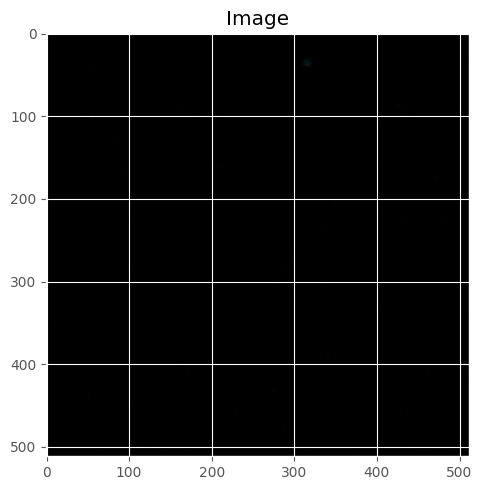

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


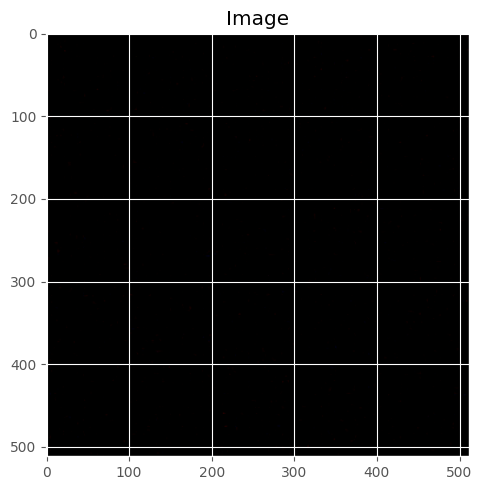

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


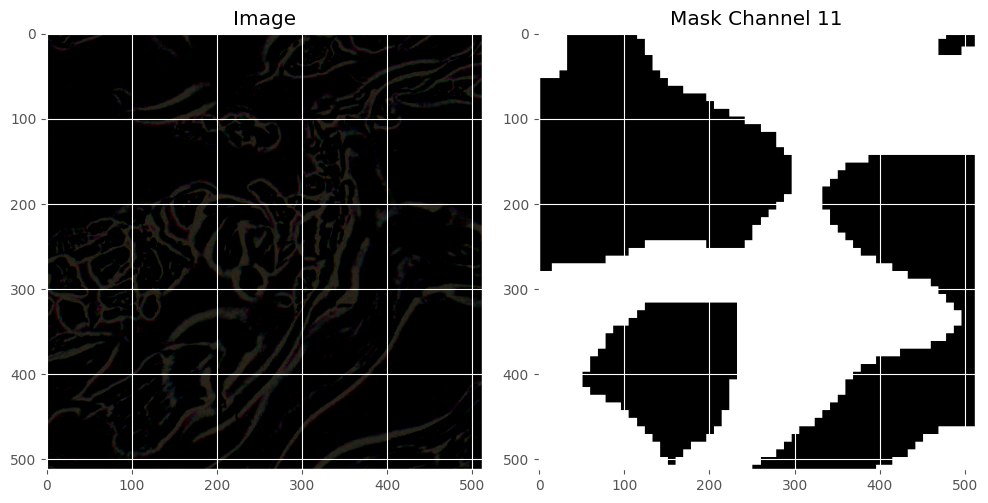

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


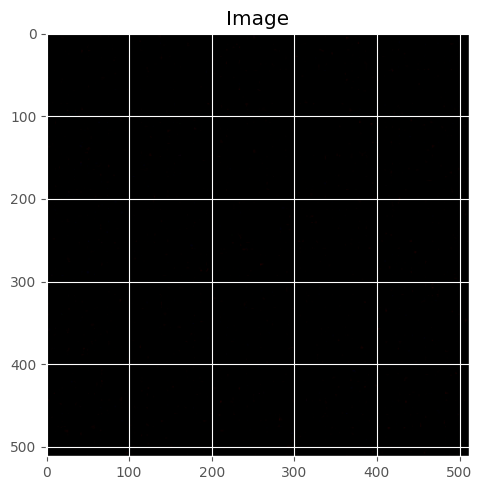

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


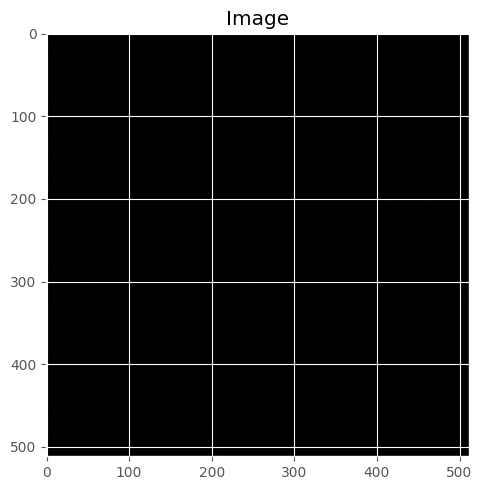

In [16]:
visualize = True
if visualize:
    model_df_train = new_df_train.query("fold!=@fold").reset_index(drop=True)
    train_dataset = TrainDataSet(df = model_df_train, transforms = train_transform) # image,mask pair
    num_images = 5
    random_indices = np.random.choice(len(train_dataset), num_images, replace=False)

    for i, idx in enumerate(random_indices):
        image, mask = train_dataset[idx]

        # Convert the image and mask tensors to numpy arrays
        image = image.numpy().transpose(1, 2, 0)
        mask = mask.numpy().transpose(1, 2, 0)  # Convert mask from (12, H, W) to (H, W, 12)

        # Normalize the image array to the range [0, 1]
        image = image / 255.0

        # Find the non-zero mask channels
        non_zero_channels = np.any(mask, axis=(0, 1))

        # Plot the image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, non_zero_channels.sum() + 1, 1)
        plt.imshow(image)
        plt.title("Image")

        # Plot each non-zero channel of the mask
        channel_idx = 2
        for j, channel in enumerate(non_zero_channels):
            if channel:
                plt.subplot(1, non_zero_channels.sum() + 1, channel_idx)
                plt.imshow(mask[:, :, j], cmap='gray')
                plt.title(f"Mask Channel {j + 1}")
                channel_idx += 1

        plt.tight_layout()
        plt.show()

### Now our problem is multilabel since labels are not mutually exclusive (each image can have more than one right answer, or label/classes). Therefore, we use sigmoid activation function for our logits (logits = raw output of model).

In [17]:
def build_model():
    model = smp.UnetPlusPlus(encoder_name=model_config.encoder_name,encoder_weights = None, activation = "sigmoid", in_channels=3,classes=12)
    model.to(model_config.device) # model to gpu
    return model

In [18]:
model = build_model()
print(model)

UnetPlusPlus(
  (encoder): TimmUniversalEncoder(
    (model): EfficientNetFeatures(
      (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): ConvBnAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (drop_path): Identity()
          )
          (1): ConvBnAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, trac

### Dice loss will measure overlap b/w predicted and GT segmentation mask and will punish inaccurate segmentations by class. Also works great for imbalanced classes, as it gives equal importance to all classes. Helps us get correct segmentation and boundaries. BCE loss is also similar, and does BCE for each class.

In [19]:
# both loss func utilizes N * C * H * W tensors for y_pred and y_true, which is indeed our case.
dice_loss_func = smp.losses.DiceLoss(mode='multilabel')
bce_loss_func = smp.losses.SoftBCEWithLogitsLoss()

def loss_func(y_pred,y_true): #weighted avg of the two, maybe explore different weighting if possible?
    return  0.5 * dice_loss_func (y_pred,y_true) + 0.5 * bce_loss_func(y_pred,y_true)


### Dice coef: 2*(A intersect B)/(A+B) for stratified K-fold CV to pick out best model:

In [20]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32) # binary tensor
    intersection = (y_true*y_pred).sum(dim=dim) # calculate overlapping pixels b/w pred and true for height and width
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim) # denominator, A+B along height and width
    dice = ((2*intersection+epsilon)/(den+epsilon)).mean(dim=(1,0)) # avg over batch & channel to return scalar
    return dice

### Training & Validation One Epoch:

In [21]:
#from: https://pytorch.org/docs/stable/notes/amp_examples.html in "working with scaled gradients"
def epoch_train(model, optimizer, scheduler, dataloader, device, epoch):
    model.train() # set mode to train
    dataset_size = 0 #initialize
    running_loss = 0.0 #initialize
    scaler = GradScaler() # enable GradScaler
    pbar = tqdm(enumerate(dataloader), total = len(dataloader), desc='Train', colour = 'red')
    for idx, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float) # move tensor to gpu
        masks  = masks.to(device, dtype=torch.float) # move tensor to gpu
        batch_size = images.size(0) # return batch size N.

        with autocast(enabled=True,dtype=torch.float16): # enable autocast for forward pass
            y_pred = model(images) # forward pass, get y_pred from input
            loss   = loss_func(y_pred, masks) # compute losses from y_pred
            loss   = loss / model_config.iters_to_accumulate # need to normalize since accumulating gradients
        scaler.scale(loss).backward() # accumulates the scaled gradients

        if (idx + 1) % model_config.iters_to_accumulate == 0: # scale updates should only happen at batch granularity
            scaler.step(optimizer)
            scaler.update() # update scale for next iteration
            optimizer.zero_grad() # zero the accumulated scaled gradients
            scheduler.step() # change lr,make sure to call this after scaler.step

        running_loss += (loss.item() * batch_size) # update current running loss for all images in batch
        dataset_size += batch_size # update current datasize

        epoch_loss = running_loss / dataset_size # get current epoch average loss
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}')

    torch.cuda.empty_cache() #clear gpu memory after every epoch
    gc.collect()

    return epoch_loss #return loss for this epoch

In [22]:
@torch.no_grad() # disable gradient calc for validation
def epoch_valid(model, dataloader, device, epoch):
    model.eval() # set mode to eval
    dataset_size = 0 #initialize
    running_loss = 0.0 #initialize
    valid_score_history = [] #keep validation score
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Validation',colour = 'red')
    for idx, (images, masks) in pbar:
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)
        y_pred  = model(images)
        loss    = loss_func(y_pred, masks)

        running_loss += (loss.item() * batch_size) #update current running loss
        dataset_size += batch_size #update current datasize
        epoch_loss = running_loss / dataset_size #divide epoch loss by current datasize

        y_pred = nn.Sigmoid()(y_pred) #sigmoid for multi-class
        valid_dice = dice_coef(masks, y_pred).cpu.detach().numpy()
        valid_score_history.append(valid_dice)

        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.3f}',
                        lr=f'{current_lr:0.4f}')
    valid_score_history = np.mean(valid_score_history, axis=0)
    torch.cuda.empty_cache() #clear gpu memory after every epoch
    gc.collect()

    return epoch_loss, valid_score_history #return loss and valid_score_history for this epoch


In [23]:
def run_training(model, optimizer, scheduler, device, num_epochs):

    start = time.time() # measure time
    best_model_wts = copy.deepcopy(model.state_dict()) #deepcopy
    best_dice      = 0 # initial best score
    best_epoch     = -1 # initial best epoch
    history = defaultdict(list) # history defaultdict to store relevant variables

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = epoch_train(model, optimizer, scheduler,
                                           dataloader=train_dataloader,
                                           device=model_config.device, epoch=epoch)
        valid_loss, valid_score_history = epoch_valid(model, val_dataloader,
                                                 device=model_config.device,
                                                 epoch=epoch)
        valid_dice = valid_score_history
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(valid_loss)
        history['Valid Dice'].append(valid_dice)

        print(f'Valid Dice: {valid_dice:0.4f}')

        # if dice score improves, save the best model
        if valid_dice >= best_dice:
            print(f"Valid Score Improved ({best_dice:0.4f} ---> {valid_dice:0.4f})")
            best_dice    = valid_dice
            best_epoch   = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = os.path.join(model_config.model_save_directory,f"best_epoch-{fold:02d}.pt")
            if not os.path.exists(model_config.model_save_directory):
                os.makedirs(model_config.model_save_directory)
            torch.save(model.state_dict(), PATH) #current directory (on kaggle)
            print("Model Saved!")

        # save the most recent model
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = os.path.join(model_config.model_save_directory,f"latest_epoch-{fold:02d}.pt")
        if not os.path.exists(model_config.model_save_directory):
            os.makedirs(model_config.model_save_directory)
        torch.save(model.state_dict(), PATH)

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60))
    print("Best Dice Score: {:.4f}".format(best_dice))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

### Now build model and train:

In [24]:
model = build_model()
optimizer = optim.Adam(model.parameters(),
                       lr=model_config.learning_rate,
                       weight_decay = model_config.weight_decay ) # default learning rate
if model_config == "CosineAnnealingLR": # change to CosineAnnealingLR
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = model_config.T_max,
                                               eta_min =  model_config.eta_min)

In [25]:
# Run Training!
for fold in range(5):
    print(f'Fold: {fold}')
    train_dataloader, valid_dataloader = load_dataset(fold = fold)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(),
                           lr=model_config.learning_rate,
                           weight_decay=model_config.weight_decay) # default learning rate

    if model_config.scheduler == "CosineAnnealingLR": # change to CosineAnnealingLR
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                                   T_max = model_config.T_max,
                                                   eta_min =  model_config.eta_min)

    model, history = run_training(model, optimizer, scheduler,
                                  device=model_config.device,
                                  num_epochs=model_config.epochs)

Fold: 0
Epoch 1/5

Train:   0%|          | 0/360 [00:00<?, ?it/s]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   0%|          | 1/360 [00:04<27:51,  4.66s/it, lr=0.00100, train_loss=0.2764]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   1%|          | 2/360 [00:07<20:30,  3.44s/it, lr=0.00100, train_loss=0.3038]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   1%|          | 3/360 [00:09<18:13,  3.06s/it, lr=0.00100, train_loss=0.2924]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   1%|          | 4/360 [00:12<17:06,  2.88s/it, lr=0.00100, train_loss=0.2862]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   1%|▏         | 5/360 [00:15<16:24,  2.77s/it, lr=0.00100, train_loss=0.2904]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   2%|▏         | 6/360 [00:17<16:04,  2.72s/it, lr=0.00100, train_loss=0.2867]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   2%|▏         | 7/360 [00:20<15:42,  2.67s/it, lr=0.00100, train_loss=0.2831]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   2%|▏         | 8/360 [00:22<15:34,  2.66s/it, lr=0.00100, train_loss=0.2807]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   2%|▎         | 9/360 [00:25<15:23,  2.63s/it, lr=0.00100, train_loss=0.2836]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   3%|▎         | 10/360 [00:28<15:20,  2.63s/it, lr=0.00100, train_loss=0.2858]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   3%|▎         | 11/360 [00:30<15:12,  2.61s/it, lr=0.00100, train_loss=0.2836]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   3%|▎         | 12/360 [00:33<15:10,  2.62s/it, lr=0.00100, train_loss=0.2813]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   4%|▎         | 13/360 [00:36<15:23,  2.66s/it, lr=0.00100, train_loss=0.2798]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   4%|▍         | 14/360 [00:38<15:31,  2.69s/it, lr=0.00100, train_loss=0.2778]

torch.Size([16, 12, 512, 512])
torch.Size([16, 12, 512, 512])


Train:   4%|▍         | 14/360 [00:41<17:04,  2.96s/it, lr=0.00100, train_loss=0.2778]

KeyboardInterrupt

